In [1]:
# from src.components.polarizationFock.light_source import SPDCSource
# from src.kernel.timeline import Timeline
# from src.components.photon import Photon
# from src.kernel.quantum_manager import POLARIZATION_FOCK_FORMALISM
# from src.utils.encoding import polarizationFock
from scipy import sparse as sp

from sequence.components.polarization_fock import light_source as seq_ls
from sequence.kernel.timeline import Timeline 
from sequence.kernel.quantum_manager import POLARIZATION_FOCK_FORMALISM

# import tensornetwork as tn
import numpy as np
from numpy.linalg import matrix_power
import qutip as qt
from numpy import kron, sqrt
from scipy import sparse as sp 
from scipy.linalg import expm
from math import factorial
from matplotlib import pyplot as plt
# plt.style.use('dark_background')

import copy
import re
import time


%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor import MatrixProductState as mps
from quimb.tensor import MatrixProductOperator as mpo
from quimb.tensor.tensor_1d import TensorNetwork1DOperator, TensorNetwork1DFlat, TensorNetwork1D, TensorNetwork1DVector
from quimb.tensor.tensor_arbgeom import get_coordinate_formatter, tensor_network_apply_op_vec
from quimb.tensor.tensor_core import rand_uuid, new_bond
from quimb.tensor.tensor_1d_compress import tensor_network_1d_compress, enforce_1d_like
from quimb.utils import oset
from quimb.tensor.tensor_core import oset_union

from autoray import do

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Support functions

In [2]:
# Vacuum state creation
def fill_fn(shape):
    arr = np.zeros(shape)
    idx = tuple([0]*(len(shape)))
    arr[idx] = 1
    return arr
def create_vacuum_state(num_modes, N, bond_dim = 2):
    return mps.from_fill_fn(
                fill_fn,
                L=num_modes,
                bond_dim=bond_dim,
                phys_dim=N,
                cyclic=False,
                tags="In"
            )

# Generating labels for reading state. 
def generate_labels(num_systems, N):
    dim = N**2
    labels = []
    state_labels = []
    for i in range(dim):
        state_labels.append(f"{i//N}H{i%N}V")
    # print("sates:", self.state_labels)
    for i in range(dim**num_systems):
        new_label = ""
        for j in range(num_systems-1, -1, -1):
            # print("appending to labels:", f"{self.state_labels[(i//self.dim**j)%self.dim]}_{chr(65+j)} ")
            new_label += f"{state_labels[(i//dim**j)%dim]}_{chr(65+j)} "
        labels.append(new_label[:-1])
    return labels

def read_quantum_state(TN_state, N, num_states = 4):
    dense_state = TN_state.to_dense()
    dense_state = np.reshape(dense_state.data, (-1, 1), order = 'C')
    dense_state = sp.csr_matrix(dense_state)
    dense_state.data = np.round(dense_state.data, 10)
    dense_state.eliminate_zeros()

    print_quantum_state(N, dense_state, num_states)

def print_quantum_state(N, dense_state, num_states = 4):
    labels = generate_labels(num_states,N)
    state = dense_state.nonzero()[0]
    print("Corresponding Basis terms:")
    for k in state: print(labels[k],"-",k,"-",dense_state[k].data)

def create_ladder_MPO(site, total_sites, N, tag="$Ladder$"):
    a = qt.destroy(N).full()
    a_dag = a.T
    TMSV_MPO = mpo.from_dense(a_dag, dims = N, sites = (site,), L=total_sites, tags=tag) 
    # return TMSV_MPO.fill_empty_sites(mode = "minimal")
    return TMSV_MPO

def create_MPO(site1, site2, total_sites, op, N, tag):
    MPO = mpo.from_dense(op, dims = N, sites = (site1,site2), L=total_sites, tags=tag)
    # new_arrays = []
    # for i in range(len(MPO.arrays)):
    #     if len(MPO.arrays[i].shape) == 3:
    #         new_arrays.append(MPO.arrays[i].reshape(-1, N, N))
    # # TMSV_MPO=mpo(TMSV_MPO.arrays)
    # MPO = mpo(new_arrays)
    # for i in MPO.arrays:
    #     print(i.shape)
    # print("Inside op")
    
    return MPO

# Beamsplitter transformation
def create_BS_MPO(site1, site2, theta, total_sites, N, tag = 'BS'): 

    a = qt.destroy(N).full()
    a_dag = a.T
    I = np.eye(N)
    
    # The V polarization would be transmitted unchanged. So, we only focus on the 
    # H polarized photons. Now, we have 2 modes of H polarized photons which need to be 
    # reflected. So, we create the unitaries for both individually and multiply them (not in this function.)

    hamiltonian_BS = -theta * ( kron(I, a_dag)@kron(a, I) - kron(I, a)@kron(a_dag, I) )
    unitary_BS = expm(hamiltonian_BS)

    BS_MPO = mpo.from_dense(unitary_BS, dims = N, sites = (site1,site2), L=total_sites, tags=tag)
    # BS_MPO = BS_MPO.fill_empty_sites(mode = "full")
    return BS_MPO

def create_POVM_OP_Dense(efficiency, outcome, N):
    a = qt.destroy(N).full()
    a_dag = a.T
    create0 = a_dag * sqrt(efficiency)
    destroy0 = a * sqrt(efficiency)
    series_elem_list = [((-1)**i) * matrix_power(create0, (i+1)) @ matrix_power(destroy0, (i+1)) / factorial(i+1) for i in range(N-1)] # (-1)^i * a_dag^(i+1) @ a^(i+1) / (i+1)! = (-1)^(i+2) * a_dag^(i+1) @ a^(i+1) / (i+1)! since goes from 0->n
    # print(series_elem_list[0])
    dense_op = sum(series_elem_list)

    if outcome == 0:
        dense_op = np.eye(dense_op.shape[0]) - dense_op
    # print(dense_op)
    return dense_op


def generate_POVM_MPO(sites, outcome, total_sites, efficiency, N, tag = "POVM"):
    dense_op = create_POVM_OP_Dense(efficiency, outcome, N)

    POVM_MPOs = []
    for i in sites:
        POVM_MPOs.append(mpo.from_dense(dense_op, dims = N, sites = (i,), L=total_sites, tags=tag))

    return POVM_MPOs

# Generate truncation filter MPO 
# TODO: Make a function to renormalize a quantum state. How: find the projection of the quantum state onto itself and calculate the 
# probability. Next, take the square root of this number, divide it by the number nodes in the quantum state and multiply it with 
# all the states in the MPS. For density matrices, simply find the trace directly and do the same thing as the previous example except
# for not taking the square root.  The truncation filter would not work without the renormalization 
def create_truncation_filter_Dense(truncation):
    # This is only the projection operator. The states need to be normalized first. 
    N = truncation+1
    vacuum = np.zeros(N**2)
    vacuum[0] = 1

    a = qt.destroy(N).full()
    a_dag = a.T
    I = np.eye(N)

    # # debug
    # labels = generate_labels(1,N)

    op = 0
    for trunc in range(truncation, -1, -1):
        state = kron(matrix_power(a_dag, trunc), I) @ vacuum / sqrt(factorial(trunc) * factorial(0))
        op+=np.outer(state, state)
        coeffs = [trunc+1, 0]

        # # Debug
        # state_inds = state.nonzero()[0]
        # print("TMSV state:", [labels[i] for i in state_inds], "Val:", state[state_inds[0]])
        # print("coeffs", coeffs)

        for i in range(trunc):
            coeffs = [coeffs[0]-1, coeffs[1]+1]
            state = kron(a, a_dag) @ state / sqrt((coeffs[0]) * (coeffs[1]))
            op += np.outer(state, state)


            # # debug
            # state_inds = state.nonzero()[0]
            # print("TMSV state:", [labels[i] for i in state_inds], "Val:", state[state_inds[0]])
            # print("coeffs", coeffs)

    return op

### Create and apply operators

Light source</br>
<centering>
<img src="light source.jpg" alt="drawing" width="500"/>
</centering>

In [3]:
# TMSV operator
def old_create_TMSV_OP_Dense(N, mean_photon_num):

    a = qt.destroy(N).full()
    a_dag = a.T
    truncation = (N-1)      

    def generate_amp_list(mean_photon_num):
        amp_list = [(sqrt(mean_photon_num / (mean_photon_num + 1)) ** m) / sqrt(mean_photon_num + 1) for m in range(truncation)]
        amp_square_list = [amp ** 2 for amp in amp_list]
        amp_list.append(sqrt(1 - sum(amp_square_list)))
        return amp_list

    amp = generate_amp_list(mean_photon_num)

    op = np.complex128(0)
    for i in range(truncation+1):
        # TMSV is a 2 mode state (independent spatial modes). Hence, we take the tensor product of the two mode operators
        new_op = amp[i] * ( matrix_power(kron(a_dag, a_dag), i) ) / factorial(i)
        op += new_op

    return op

def create_TMSV_OP_Dense(N, mean_photon_num):
    a = qt.destroy(N).full()
    a_dag = a.T
    truncation = (N-1)   

    op = expm(1j * mean_photon_num * (kron(a_dag, a_dag) + kron(a, a)))

    return op


def light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress = True, contract = True):

    psi = vacuum.copy()
    psi.add_tag("L0")
    site_tags = psi.site_tags

    # Creating TMSV ops:
    TMSV_op_dense = create_TMSV_OP_Dense(N, mean_photon_num)

    TMSV_MPO_H = create_MPO(site1 = 0, site2 = 2, total_sites = num_modes, op = TMSV_op_dense, N = N, tag = r"$TMSV_H$")
    enforce_1d_like(TMSV_MPO_H, site_tags=site_tags, inplace=True)
    TMSV_MPO_H.add_tag("L1")

    TMSV_MPO_V = create_MPO(site1 = 5, site2 = 7, total_sites = num_modes, op = TMSV_op_dense, N = N, tag = r"$TMSV_V$")
    enforce_1d_like(TMSV_MPO_V, site_tags=site_tags, inplace=True)
    TMSV_MPO_V.add_tag("L1")

    # Creating PBS ops:
    U_PBS_H_Signal = create_BS_MPO(site1 = 2, site2 = 6, theta=np.pi/2, total_sites = num_modes, N = N, tag = r"$PBS_S$")
    enforce_1d_like(U_PBS_H_Signal, site_tags=site_tags, inplace=True)
    U_PBS_H_Signal.add_tag("L1")

    U_PBS_H_Idler = create_BS_MPO(site1 = 0, site2 = 4, theta=np.pi/2, total_sites = num_modes, N = N, tag = r"$PBS_I$")
    enforce_1d_like(U_PBS_H_Idler, site_tags=site_tags, inplace=True)
    U_PBS_H_Signal.add_tag("L1")

    # Create entangled state:
    psi = tensor_network_apply_op_vec(TMSV_MPO_H, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(TMSV_MPO_V, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(U_PBS_H_Idler, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(U_PBS_H_Signal, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    psi.normalize()

    # print("trace is:", np.linalg.norm(psi.to_dense()))

    for _ in range(4):
        psi.measure(0, remove = True, renorm = True, inplace = True)

    # Not used for TN implermentation. Used for validating impelmentation with dense version
    TMSV_state = psi.to_dense()
    TMSV_state = np.reshape(TMSV_state.data, (-1, 1), order = 'C')
    TMSV_state = sp.csr_matrix(TMSV_state)
    TMSV_state.data = np.round(TMSV_state.data, 10)
    TMSV_state.eliminate_zeros()

    return psi, TMSV_state

def new_ls(N, mean_photon_num, error_tolerance, compress = True, contract = True):
    trunc = N-1
    spdc = seq_ls.SPDCSource("", Timeline(formalism=POLARIZATION_FOCK_FORMALISM, truncation = trunc))
    dense_state = spdc._generate_tmsv_state(dm = False).toarray()

    psi = mps.from_dense(psi = dense_state, dims = N, tags = "ENT", cutoff = error_tolerance)
    return psi

# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance)

In [11]:
# N = 3
# a = qt.destroy(N).full()
# a_dag = a.T
# truncation = (N-1)      

# def generate_amp_list(mean_photon_num):
#     amp_list = [(sqrt(mean_photon_num / (mean_photon_num + 1)) ** m) / sqrt(mean_photon_num + 1) for m in range(truncation)]
#     amp_square_list = [amp ** 2 for amp in amp_list]
#     amp_list.append(sqrt(1 - sum(amp_square_list)))
#     return amp_list

#     amp = generate_amp_list(mean_photon_num)

# generate_amp_list(0.5)
N = 5
trunc = N-1
chi = 0.5
error_tolerance = 1e-10

vac = np.zeros(N**2)
vac[0] = 1


op = old_create_TMSV_OP_Dense(N, chi)
dense_state = op @ vac

print(np.linalg.norm(dense_state))

labels = generate_labels(1,N)
state = dense_state.nonzero()[0]
print("Corresponding Basis terms:")
for k in state: print(labels[k],"-",k,"-",dense_state[k])



# print(state)

def new_create_TMSV_OP_Dense(N, mean_photon_num):
    a = qt.destroy(N).full()
    a_dag = a.T
    truncation = (N-1)   

    op = expm(1j * mean_photon_num * (kron(a_dag, a_dag) + kron(a, a)))

    return op

op = new_create_TMSV_OP_Dense(N, chi)
dense_state = op @ vac

print(np.linalg.norm(dense_state))

labels = generate_labels(1,N)
state = dense_state.nonzero()[0]
print("Corresponding Basis terms:")
for k in state: print(labels[k],"-",k,"-",dense_state[k])
    # amp_list = [(sqrt(mean_photon_num / (mean_photon_num + 1)) ** m) / sqrt(mean_photon_num + 1) for m in range(truncation)]
    # amp_square_list = [amp ** 2 for amp in amp_list]
    # amp_list.append(sqrt(1 - sum(amp_square_list)))
    # return amp_list


spdc = seq_ls.SPDCSource("", Timeline(formalism=POLARIZATION_FOCK_FORMALISM, truncation = trunc))
dense_state = spdc._generate_tmsv_state(dm = False)
# print("type:", type(dense_state.toarray()))

labels = generate_labels(2,N)
state = dense_state.nonzero()[0]
print("Corresponding Basis terms:")
for k in state: print(labels[k],"-",k,"-",dense_state[k].data)

psi = new_ls(N, chi, error_tolerance)

read_quantum_state(psi, N, num_states = 2)

num_modes = 8

vacuum = create_vacuum_state(num_modes=num_modes, N=N)
psi, TMSV_state = light_source(vacuum, N, chi, num_modes, error_tolerance)
# print(psi)
read_quantum_state(psi, N, num_states = 2)

1.0
Corresponding Basis terms:
0H0V_A - 0 - (0.8164965809277261+0j)
1H1V_A - 6 - (0.4714045207910317+0j)
2H2V_A - 12 - (0.27216552697590873+0j)
3H3V_A - 18 - (0.15713484026367722+0j)
4H4V_A - 24 - (0.11111111111111034+0j)
0.9999999999999999
Corresponding Basis terms:
0H0V_A - 0 - (0.8868219804424583+0j)
1H1V_A - 6 - 0.40975501484366017j
2H2V_A - 12 - (-0.18988532920021292+0j)
3H3V_A - 18 - -0.0850089395396592j
4H4V_A - 24 - (0.04862761321982728+0j)


Corresponding Basis terms:
0H0V_B 0H0V_A - 0 - [0.90910143]
0H1V_B 0H1V_A - 26 - [0.27410439]
0H2V_B 0H2V_A - 52 - [0.08264558]
0H3V_B 0H3V_A - 78 - [0.02491858]
0H4V_B 0H4V_A - 104 - [0.00787995]
1H0V_B 1H0V_A - 130 - [0.27410439]
1H1V_B 1H1V_A - 156 - [0.08264558]
1H2V_B 1H2V_A - 182 - [0.02491858]
1H3V_B 1H3V_A - 208 - [0.00751323]
2H0V_B 2H0V_A - 260 - [0.08264558]
2H1V_B 2H1V_A - 286 - [0.02491858]
2H2V_B 2H2V_A - 312 - [0.00751323]
3H0V_B 3H0V_A - 390 - [0.02491858]
3H1V_B 3H1V_A - 416 - [0.00751323]
4H0V_B 4H0V_A - 520 - [0.00787995]
Corresponding Basis terms:
0H0V_B 0H0V_A - 0 - [0.90910143]
0H1V_B 0H1V_A - 26 - [0.27410439]
0H2V_B 0H2V_A - 52 - [0.08264558]
0H3V_B 0H3V_A - 78 - [0.02491858]
0H4V_B 0H4V_A - 104 - [0.00787995]
1H0V_B 1H0V_A - 130 - [0.27410439]
1H1V_B 1H1V_A - 156 - [0.08264558]
1H2V_B 1H2V_A - 182 - [0.02491858]
1H3V_B 1H3V_A - 208 - [0.00751323]
2H0V_B 2H0V_A - 260 - [0.08264558]
2H1V_B 2H1V_A - 286 - [0.02491858]
2H2V_B 2H2V_A - 312 - [0.00751323]
3H0V_B 3H0V

Extend MPS (in this case, with itself since we have two sources). 

In [5]:
def extend_MPS(psi):
    psi.permute_arrays('lrp')

    # This is supposed to be passed as the second MPS to extend the first MPS with. 
    psi_second = psi.copy()
    
    psi_num_modes = len(psi.site_tags)
    psi2_num_modes = len(psi_second.site_tags)

    psi_second.reindex({f"k{i}":f"k{i+psi_num_modes}" for i in range(psi2_num_modes)}, inplace = True)
    psi_second.retag({f"I{i}":f"I{i+psi_num_modes}" for i in range(psi2_num_modes)}, inplace = True)

    psi = psi.combine(psi_second)

    psi_last_tensor = psi.select_tensors(f"I{psi_num_modes-1}", which='any')[0]
    psi2_first_tensor = psi.select_tensors(f"I{psi_num_modes}", which='any')[0]

    new_bond(psi2_first_tensor, psi_last_tensor, axis1=0, axis2=1)

    pattern = re.compile(r"I[0-9][0-9]*")
    tags = []
    for tag_list in [t.tags for t in psi]:
        for tag in tag_list:
            match = re.search(pattern, tag)
            if match:
                tags.append(match.string)
                break
            
    sorted_arrays = [array for array, _ in sorted(zip(psi.arrays, tags), key = lambda pair: pair[1])]

    psi = mps(sorted_arrays)

    psi.add_tag("L1")
    psi.add_tag(r'$HH+VV$')

    return psi

# psi = extend_MPS(psi)

Perform the Bell state measurement

In [6]:
def bell_state_measurement(psi, N, site_tags, num_modes, efficiency, error_tolerance, compress = True, contract = True):

    U_BS_H = create_BS_MPO(site1 = 2, site2 = 6, theta=np.pi/4, total_sites = num_modes, N = N, tag = r"$U_{BS_H}$")
    enforce_1d_like(U_BS_H, site_tags=site_tags, inplace=True)
    U_BS_H.add_tag("L2")

    U_BS_V = create_BS_MPO(site1 = 3, site2 = 7, theta=np.pi/4, total_sites = num_modes, N = N, tag = r"$U_{BS_V}$")
    enforce_1d_like(U_BS_V, site_tags=site_tags, inplace=True)
    U_BS_V.add_tag("L3")

    BSM_POVM_1_OPs = generate_POVM_MPO(sites=(2,7), outcome = 1, total_sites=num_modes, efficiency=efficiency, N=N)
    BSM_POVM_1_OPs.extend(generate_POVM_MPO(sites=(3,6), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N))


    psi = tensor_network_apply_op_vec(U_BS_H, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(U_BS_V, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    for POVM_OP in BSM_POVM_1_OPs:
        POVM_OP.add_tag("L4")
        psi = tensor_network_apply_op_vec(POVM_OP, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    return psi

# psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)

In [7]:
def rotate_and_measure(psi, N, site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress = True, contract = True, draw = False):
    # idler_angles = [0]
    # angles = [np.pi/4]

    coincidence = []

    POVM_1_OPs = generate_POVM_MPO(sites=(0,4), outcome = 1, total_sites=num_modes, efficiency=efficiency, N=N)
    # POVM_0_OPs = generate_POVM_MPO(sites=(1,5), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N)
    # POVM_0_OPs = generate_POVM_MPO(sites=(0,4), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N)
    # enforce_1d_like(POVM_OP, site_tags=site_tags, inplace=True)

    meas_ops = POVM_1_OPs
    # meas_ops.extend(POVM_0_OPs)

    for i, idler_angle in enumerate(idler_angles):
        coincidence_probs = []

        rotator_node_1 = create_BS_MPO(site1 = 0, site2 = 1, theta=idler_angle, total_sites = num_modes, N = N, tag = r"$Rotator_I$")
        enforce_1d_like(rotator_node_1, site_tags=site_tags, inplace=True)
        rotator_node_1.add_tag("L5")
        idler_rotated_psi = tensor_network_apply_op_vec(rotator_node_1, psi, compress=compress, contract = contract, cutoff = error_tolerance)


        for j, angle in enumerate(signal_angles):
            # print("idler:", i, "signal:", j)
        
            rotator_node_2 = create_BS_MPO(site1 = 4, site2 = 5, theta=angle, total_sites = num_modes, N = N, tag = r"$Rotator_S$")
            enforce_1d_like(rotator_node_2, site_tags=site_tags, inplace=True)
        
            # Rotate and measure:
            rotator_node_2.add_tag("L5")
            rho_rotated = tensor_network_apply_op_vec(rotator_node_2, idler_rotated_psi, compress=compress, contract = contract, cutoff = error_tolerance)

            # read_quantum_state(psi)
            # read_quantum_state(rho_rotated)

            for POVM_OP in meas_ops:
                POVM_OP.add_tag("L6")
                rho_rotated = tensor_network_apply_op_vec(POVM_OP, rho_rotated, compress=compress, contract = contract, cutoff = error_tolerance)
        
            if draw:
                rho_rotated.draw(color = [r'$HH+VV$', r'$U_{BS_H}$', r"$U_{BS_V}$", 'POVM', r'$Rotator_I$', r'$Rotator_S$'], title = "Polarization entanglement swapping MPS", fix = fix, show_inds = True, show_tags = False)
                # rho_rotated.draw_tn()
            coincidence_probs.append((rho_rotated.norm())**2)
        coincidence.append(coincidence_probs)
    
    return coincidence

# coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)

35.57887649536133


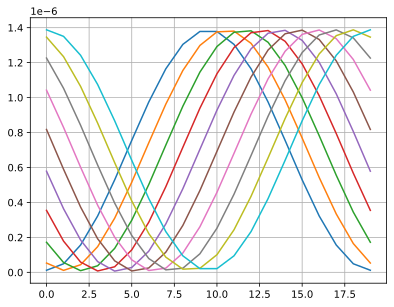

In [13]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = 0.06
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
# psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

plt.grid()
for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

80.22426652908325


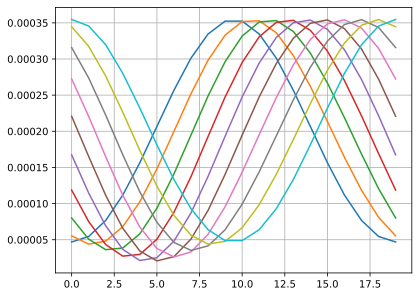

In [ ]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = np.sqrt(0.06)
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

plt.grid()
for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

237.84472703933716


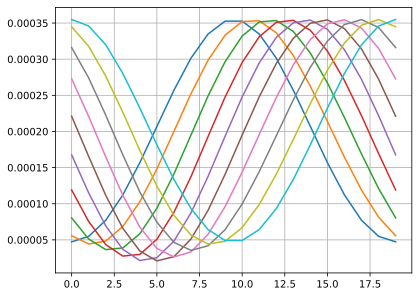

In [9]:
# params
trunc = 4
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = np.sqrt(0.06)
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

plt.grid()
for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

### Statevector version

In [9]:
from numpy import kron
import scipy.sparse as sp

a = qt.destroy(N).full()
a = sp.csr_matrix(a)
a_dag = a.T

# Support functions:
def create_op(left_indices, op, right_indices):
    if left_indices == 0:
        return sp.kron(op, sp.eye(N**right_indices))
    elif right_indices == 0:
        return sp.kron(sp.eye(N**left_indices), op)
    else:    
        out_op = sp.kron(sp.eye(N**left_indices), op)
        return sp.kron(out_op, sp.eye(N**right_indices))
def _find_mat_exp(mat):
    ans = sp.eye(mat.shape[0])
    intermediate = 1
    for i in range(1, 50+1):
        intermediate *= mat/i
        intermediate.eliminate_zeros()
        ans += intermediate
    return ans 
def read_quantum_state_sparse(sparse_state, N):
    temp_sparse_state = sp.csr_matrix(sparse_state)
    temp_sparse_state.data = np.round(temp_sparse_state.data, 10)
    temp_sparse_state.eliminate_zeros()
    labels = generate_labels(4,N)
    state = temp_sparse_state.nonzero()[0]
    print(f"{len(state)} non-zero elements Corresponding Basis terms:")
    for k in state: print(labels[k],"-",k,"-",temp_sparse_state[k].data)

def extend_state_sparse(state):
    return sp.kron(state, state)
# TMSV_state_dense = extend_state_sparse(TMSV_state)

def bell_state_measurement_sparse(TMSV_state_dense, N, efficiency):
    # BSM BS implementation
    BSM_H_0_Mode_op = create_op(2, a_dag, 5)
    print(BSM_H_0_Mode_op.shape, len(BSM_H_0_Mode_op.nonzero()[0]), len(BSM_H_0_Mode_op.nonzero()[1]))
    BSM_V_0_Mode_op = create_op(3, a_dag, 4)
    BSM_H_1_Mode_op = create_op(6, a_dag, 1)
    BSM_V_1_Mode_op = create_op(7, a_dag, 0)
    hamiltonian_BS_H = -np.pi/4 * ( BSM_H_0_Mode_op.T@BSM_H_1_Mode_op - BSM_H_0_Mode_op@BSM_H_1_Mode_op.T )
    unitary_BS_H = _find_mat_exp(hamiltonian_BS_H)

    hamiltonian_BS_V = -np.pi/4 * ( BSM_V_0_Mode_op.T@BSM_V_1_Mode_op - BSM_V_0_Mode_op@BSM_V_1_Mode_op.T )
    unitary_BS_V = _find_mat_exp(hamiltonian_BS_V)


    # BSM povm implementation
    povm_op_1 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 1, N))
    povm_op_0 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 0, N))

    BSM_povm = create_op(2, povm_op_1, 0)
    BSM_povm = create_op(0, sp.kron(BSM_povm, povm_op_0), 2)
    BSM_povm = sp.kron(BSM_povm, sp.kron(povm_op_0, povm_op_1))

    # print(unitary_BS_V.shape, unitary_BS_H.shape, TMSV_state_dense.shape)
    
    post_BS_State = unitary_BS_V @ unitary_BS_H @ TMSV_state_dense
    post_BSM_State = BSM_povm @ post_BS_State

    return post_BSM_State
# post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)

def rotate_and_measure_sparse(post_BSM_State, N, efficiency):
    # Polarization rotators mode operators
    rotator_H_0_Mode_op = create_op(0, a_dag, 7)
    rotator_V_0_Mode_op = create_op(1, a_dag, 6)
    rotator_H_1_Mode_op = create_op(4, a_dag, 3)
    rotator_V_1_Mode_op = create_op(5, a_dag, 2)

    povm_op_1 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 1, N))

    # polarization analysis detector POVMs
    pol_analyzer_povm = create_op(0, povm_op_1, 3)
    pol_analyzer_povm = create_op(0, sp.kron(pol_analyzer_povm, povm_op_1), 3)

    # Applying rotations and measuring

    signal_angles = np.linspace(0, np.pi, 10)
    # idler_angles = np.linspace(0, np.pi, 20)
    idler_angles = [0]
    coincidence = []

    for i, idler_angle in enumerate(idler_angles):
        coincidence_probs = []

        hamiltonian_rotator_1 = -idler_angle * ( rotator_H_1_Mode_op.T@rotator_V_1_Mode_op - rotator_H_1_Mode_op@rotator_V_1_Mode_op.T )
        unitary_rotator_1 = _find_mat_exp(hamiltonian_rotator_1)
        post_idler_detection_state = unitary_rotator_1 @ post_BSM_State
        # post_idler_detection_state = post_BSM_State
        
        for j, angle in enumerate(signal_angles):
            # print("idler:", i, "signal:", j)
        
            hamiltonian_rotator_0 = -angle * ( rotator_H_0_Mode_op.T@rotator_V_0_Mode_op - rotator_H_0_Mode_op@rotator_V_0_Mode_op.T )
            unitary_rotator_0 = _find_mat_exp(hamiltonian_rotator_0)
            post_rotations_state = unitary_rotator_0 @ post_idler_detection_state

            measured_state = pol_analyzer_povm @ post_rotations_state

            coincidence_probs.append(sp.linalg.norm(measured_state)**2)
        coincidence.append(coincidence_probs)
    return coincidence, idler_angles
# coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)

done with extension
(65536, 65536) 49152 49152
done with bell_state_measurement_sparse
done with rotate_and_measure_sparse


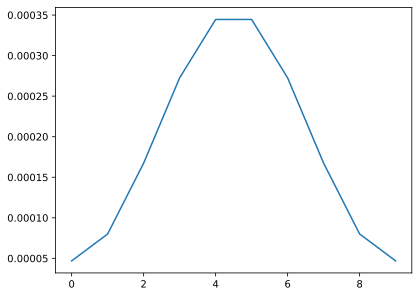

In [10]:
# read_quantum_state_sparse(TMSV_state, N)

TMSV_state_dense = extend_state_sparse(TMSV_state)
print("done with extension")
# read_quantum_state_sparse(TMSV_state_dense, N)
post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)
print("done with bell_state_measurement_sparse")

# state_indices, _ = post_BSM_State.nonzero()
# num_photons = 2
# for n in state_indices:
#     for i in range(num_photons):
#         H = (n // (N**(2*i+1))) % N
#         V = (n // (N**(2*i+0))) % N
#         # print("n:", n, "H:", H, "V:", V, "i", i, "Val:", entangled_state[n,0])
#         if H+V > trunc:
#             # print("deleted:", n)
#             post_BSM_State[n,0] = 0  

# read_quantum_state_sparse(post_BSM_State, N) 

# read_quantum_state_sparse(post_BSM_State, N)
coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)
print("done with rotate_and_measure_sparse")

for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

Performance comparisons

In [11]:
# params
mean_photon_num = 0.2
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15
truncations = [1,2,3,4,5,6]
error_tolerances = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
TN_data = []
sparse_data = []

num_iter = 5

for error_tolerance in error_tolerances:
    TN_data_error_tol = []
    for trunc in truncations:
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        time_taken = 0
        for iter in range(num_iter):
            psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, initial_error_tolerance)
            # TN data:
            start = time.time()
            psi = extend_MPS(psi)
            psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)
            idler_angles = [0]
            coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles)
            time_taken += time.time() - start
        
        TN_data_error_tol.append(time_taken/num_iter)
        
        print("truncation:", trunc)
    print("error:", error_tolerance)
    TN_data.append(TN_data_error_tol)

truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-05
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-06
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-07
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-08
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-09
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-10


In [12]:
corrected_TN_data = []
for i in TN_data[:6]:
    corrected_TN_data.append([2*j for j in i])
corrected_TN_data

[[0.37795286178588866,
  0.49544363021850585,
  1.160251522064209,
  1.8715259552001953,
  3.6817642211914063,
  6.2446390151977536],
 [0.37921533584594724,
  0.5582192420959473,
  2.207474422454834,
  4.248854732513427,
  5.60923137664795,
  8.473978233337402],
 [0.3784365653991699,
  0.5515198707580566,
  2.335206699371338,
  5.527664089202881,
  8.341994571685792,
  12.478046989440918],
 [0.37646961212158203,
  0.7961133003234864,
  6.180577373504638,
  9.55179042816162,
  14.224153995513916,
  19.299321365356445],
 [0.39735660552978513,
  0.9513609886169434,
  5.009572887420655,
  10.528872203826904,
  15.55453701019287,
  22.058192825317384],
 [0.38264780044555663,
  0.9167355537414551,
  8.105130481719971,
  14.237593746185302,
  23.17667531967163,
  33.90475454330444]]

[0.37795286178588866, 0.49544363021850585, 1.160251522064209, 1.8715259552001953, 3.6817642211914063, 6.2446390151977536] 1e-05
[0.37921533584594724, 0.5582192420959473, 2.207474422454834, 4.248854732513427, 5.60923137664795, 8.473978233337402] 1e-06
[0.3784365653991699, 0.5515198707580566, 2.335206699371338, 5.527664089202881, 8.341994571685792, 12.478046989440918] 1e-07
[0.37646961212158203, 0.7961133003234864, 6.180577373504638, 9.55179042816162, 14.224153995513916, 19.299321365356445] 1e-08
[0.39735660552978513, 0.9513609886169434, 5.009572887420655, 10.528872203826904, 15.55453701019287, 22.058192825317384] 1e-09
[0.38264780044555663, 0.9167355537414551, 8.105130481719971, 14.237593746185302, 23.17667531967163, 33.90475454330444] 1e-10


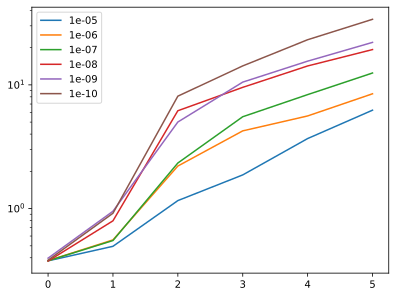

In [13]:

for i in range(len(corrected_TN_data)):
    plt.plot(corrected_TN_data[i], label=f"{error_tolerances[i]}")
    print(corrected_TN_data[i], error_tolerances[i])
plt.legend()
plt.yscale('log')


In [ ]:
sparse_data = []
num_iter = 2
for trunc in truncations:

    a = qt.destroy(trunc+1).full()
    a = sp.csr_matrix(a)
    a_dag = a.T
    
    time_taken = 0
    for iter in range(num_iter):
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, initial_error_tolerance)

        start = time.time()
        # Sparse matrix data:
        TMSV_state_dense = extend_state_sparse(TMSV_state)
        post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)
        coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)

        time_taken += time.time() - start
        print("iter:", iter)

    sparse_data.append(time_taken/num_iter)
    print(trunc)



(256, 256) 128 128
iter: 0
(256, 256) 128 128
iter: 1
1
(6561, 6561) 4374 4374
iter: 0
(6561, 6561) 4374 4374
iter: 1
2
(65536, 65536) 49152 49152
iter: 0
(65536, 65536) 49152 49152
iter: 1
3
(390625, 390625) 312500 312500
iter: 0
(390625, 390625) 312500 312500
iter: 1
4
(1679616, 1679616) 1399680 1399680


{1e-05: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-06: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-07: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-08: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-09: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-10: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736]}


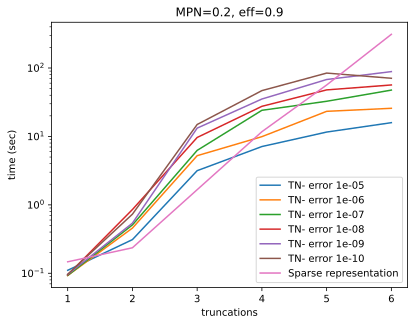

In [ ]:
import json
for i in range(len(corrected_TN_data)):
    plt.plot(truncations, corrected_TN_data[i], label=f"TN- error {error_tolerances[i]}")
plt.plot(truncations, sparse_data, label="Sparse representation")
plt.legend()
plt.yscale('log')
plt.ylabel("time (sec)")
plt.xlabel("truncations")
plt.title("MPN=0.2, eff=0.9")

time_dict_TN = {err:times for err in error_tolerances for times in corrected_TN_data}
time_sparse = sparse_data
truncations = truncations
print(time_dict_TN)

json_file = open("projects/swapping/timing_analysis/TN_data_mpn02.json", "a+")
json.dump(time_dict_TN, json_file)
sparse_data_file = open("projects/swapping/timing_analysis/sparse_data_mpn02.txt", "a+")
np.savetxt(sparse_data_file, time_sparse)
# truncations_file = open("projects/swapping/timing_analysis/truncations.txt", "a+")
# np.savetxt(truncations_file, truncations)

In [ ]:
print()

### Create density matrix

In [ ]:
psi_H = psi.H
# psi_H.retag_({'I{}': 'Out{}'})
psi_H.site_ind_id = 'b{}'
psi_H.combine(psi)
rho = (psi_H | psi)

for i in range(rho.L):
    rho ^= f"I{i}"
    
rho = rho.fuse_multibonds()   
rho = mpo(rho.arrays)
rho.compress(cutoff = 1e-5)

rho